In [ ]:
# Install necessary libraries
!pip install diffusers datasets transformers accelerate scipy ftfy

import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from torch.nn import functional as F
from matplotlib import pyplot as plt

# Suppress warnings
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

# Load your own dataset
#dataset = load_dataset("your-dataset-here", split="train")  # Example dataset, replace with your dataset


#dataset = load_dataset("AlvaroVasquezAI/Animal_Image_Classification_Dataset")

dataset = load_dataset("nirmalendu01/animal_dataset", "images")

# Create a subset of the first 1024 images
# Access the 'train' split before applying select
dataset = dataset['train'].select(range(1024))

# Check the length of the subset
print(f"Length of the subset: {len(dataset)}")

# Preprocessing
image_size = 64
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples

# Apply the transform to the dataset
dataset.set_transform(transform)

# Create a custom dataset class to return tensors directly
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]  # Return tensor directly

# Wrap the dataset in the custom class
tensor_dataset = TensorDataset(dataset)

# Create dataloader
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# Model and scheduler
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 40  # Adjust as needed

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch.to("cuda")  # Move batch to GPU
        noise = torch.randn(clean_images.shape).to("cuda")
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device="cuda").long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

# Save the model
# Replace with your desired path
torch.save(model.state_dict(), "animal_diffusion_model.pth")

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

Length of the subset: 1024
Epoch 0, Step 0: Loss = 1.067569375038147
Epoch 1, Step 0: Loss = 0.36813586950302124
Epoch 2, Step 0: Loss = 0.1978023499250412
Epoch 3, Step 0: Loss = 0.09321729838848114
Epoch 4, Step 0: Loss = 0.13936811685562134
Epoch 5, Step 0: Loss = 0.1182311400771141
Epoch 6, Step 0: Loss = 0.10252748429775238
Epoch 7, Step 0: Loss = 0.0794328823685646
Epoch 8, Step 0: Loss = 0.061498355120420456
Epoch 9, Step 0: Loss = 0.03745240345597267
Epoch 10, Step 0: Loss = 0.04732486605644226
Epoch 11, Step 0: Loss = 0.060261018574237823
Epoch 12, Step 0: Loss = 0.044235073029994965
Epoch 13, Step 0: Loss = 0.11735913157463074
Epoch 14, Step 0: Loss = 0.04021591320633888
Epoch 15, Step 0: Loss = 0.08993859589099884
Epoch 16, Step 0: Loss = 0.04543466120958328
Epoch 17, Step 0: Loss = 0.09355168044567108
Epoch 18, Step 0: Loss = 0.06399692595005035
Epoch 19, Step 0: Loss = 0.05240612477064133
Epoch 20, Step 0: Loss = 0.03898544982075691
Epoch 21, Step 0: Loss = 0.0351115725934

Length of the dataset: 1024


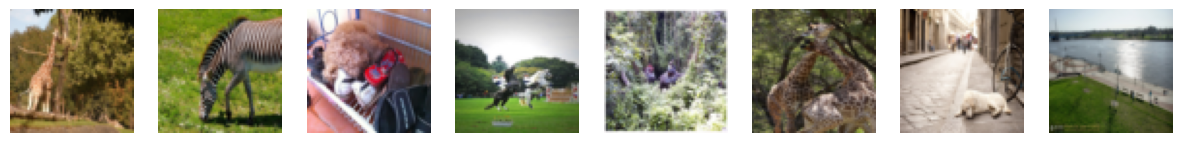

In [ ]:
# Check the length of the dataset
print(f"Length of the dataset: {len(dataset)}")

# Visualize some images from the dataset
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]["pixel_values"]  # Access the preprocessed tensor
        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

# Visualize 5 images
visualize_images(dataset, num_images=8)

## Generate images from the trained model

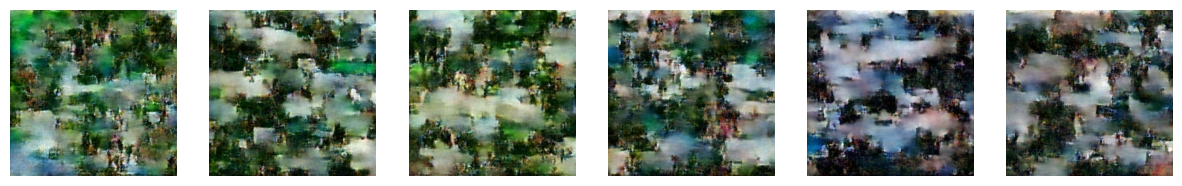

In [ ]:
import torch
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt

# Load the trained model
model = UNet2DModel(
    sample_size=64,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Function to generate images
def generate_images(num_images=1):
    with torch.no_grad():  # Disable gradient computation
        # Start from random noise
        noise = torch.randn((num_images, 3, 256, 256)).to("cuda")  # Match input dimensions
        images = noise

        # Denoising loop
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(images, t).sample

            # Compute the previous noisy sample x_t-1
            images = noise_scheduler.step(noise_pred, t, images).prev_sample

        # Convert images to CPU and denormalize
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        images = torch.clamp(images, 0, 1)  # Clamp to valid pixel range
        return images

# Generate and visualize images
num_images = 6
generated_images = generate_images(num_images)

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

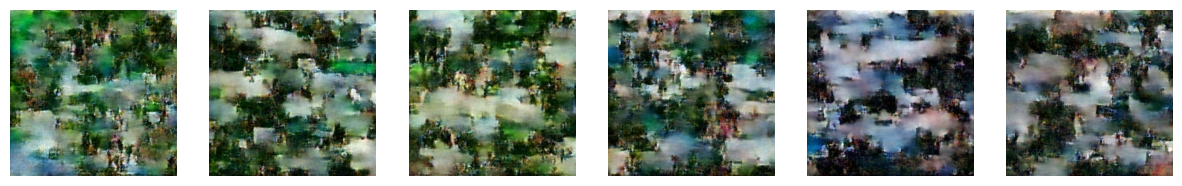

In [ ]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
os.makedirs("images", exist_ok=True)

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")

    # Save each image with a zero-padded two-digit number
    filename = f"images/animal_{i:02d}.png"
    plt.imsave(filename, img.numpy())

# Save the entire grid of images
plt.savefig("images/animal_grid.png")
plt.show()

In [ ]:
# !rm -rf images/

# Utility to zip a file
import shutil
shutil.make_archive("animals", "zip", "images")

'/content/animals.zip'

# Task
Generate 50 images of imagined animals using the diffusion model, with a resolution of 64x64, and then save and zip these generated images into "animals.zip".

## Adjust Image Generation Parameters

### Subtask:
Modify the image generation code in cell O_UClDznZVbL to generate 50 images instead of 6, and correct the generated image resolution from 256x256 to 64x64 to match the model's training size. This is crucial for successful image generation.


**Reasoning**:
The subtask requires modifying the image generation code to produce 50 images and correcting the resolution to 64x64. I will provide the updated code for cell `O_UClDznZVbL`.



In [ ]:
import torch
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt

# Load the trained model
model = UNet2DModel(
    sample_size=64,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Function to generate images
def generate_images(num_images=1):
    with torch.no_grad():  # Disable gradient computation
        # Start from random noise
        noise = torch.randn((num_images, 3, 64, 64)).to("cuda")  # Corrected resolution to 64x64
        images = noise

        # Denoising loop
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(images, t).sample

            # Compute the previous noisy sample x_t-1
            images = noise_scheduler.step(noise_pred, t, images).prev_sample

        # Convert images to CPU and denormalize
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        images = torch.clamp(images, 0, 1)  # Clamp to valid pixel range
        return images

# Generate and visualize images
num_images = 50 # Changed to generate 50 images
generated_images = generate_images(num_images)

# Plot the generated images
# For visualization, we will only plot a subset of the 50 images to avoid cluttering
# The actual saving of all 50 images will be handled in the next cell.
fig, axes = plt.subplots(1, 8, figsize=(20, 3)) # Displaying 8 images for brevity
for i, img in enumerate(generated_images[:8]): # Plotting first 8 images
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.suptitle(f"First 8 of {num_images} Generated Images")
plt.show()

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


FileNotFoundError: [Errno 2] No such file or directory: 'animal_diffusion_model.pth'

**Reasoning**:
The previous execution failed with a `FileNotFoundError` because the trained model file `animal_diffusion_model.pth` could not be found. To fix this, I will modify cell `O_UClDznZVbL` to include a check for the model file. If the file is missing, the code will now retrain and save the model before proceeding with image generation. This makes the cell self-sufficient and robust against missing model files.



Model file 'animal_diffusion_model.pth' not found. Retraining the model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

images/train-00000-of-00025.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

images/train-00001-of-00025.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

images/train-00002-of-00025.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

images/train-00003-of-00025.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

images/train-00004-of-00025.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

images/train-00005-of-00025.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

images/train-00006-of-00025.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

images/train-00007-of-00025.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

images/train-00008-of-00025.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

images/train-00009-of-00025.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

images/train-00010-of-00025.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

images/train-00011-of-00025.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

images/train-00012-of-00025.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

images/train-00013-of-00025.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

images/train-00014-of-00025.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

images/train-00015-of-00025.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

images/train-00016-of-00025.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

images/train-00017-of-00025.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

images/train-00018-of-00025.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

images/train-00019-of-00025.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

images/train-00020-of-00025.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

images/train-00021-of-00025.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

images/train-00022-of-00025.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

images/train-00023-of-00025.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

images/train-00024-of-00025.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23989 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

Starting retraining for 40 epochs...
Epoch 0, Step 0: Loss = 1.0680851936340332
Epoch 1, Step 0: Loss = 0.37412378191947937
Epoch 2, Step 0: Loss = 0.14915713667869568
Epoch 3, Step 0: Loss = 0.12107761949300766
Epoch 4, Step 0: Loss = 0.11697554588317871
Epoch 5, Step 0: Loss = 0.1428385078907013
Epoch 6, Step 0: Loss = 0.06332341581583023
Epoch 7, Step 0: Loss = 0.13863013684749603
Epoch 8, Step 0: Loss = 0.08512534946203232
Epoch 9, Step 0: Loss = 0.08632159233093262
Epoch 10, Step 0: Loss = 0.041053175926208496
Epoch 11, Step 0: Loss = 0.052171118557453156
Epoch 12, Step 0: Loss = 0.11376171559095383
Epoch 13, Step 0: Loss = 0.10162097215652466
Epoch 14, Step 0: Loss = 0.07316291332244873
Epoch 15, Step 0: Loss = 0.07085013389587402
Epoch 16, Step 0: Loss = 0.032152581959962845
Epoch 17, Step 0: Loss = 0.04469385743141174
Epoch 18, Step 0: Loss = 0.08338961005210876
Epoch 19, Step 0: Loss = 0.04046811908483505
Epoch 20, Step 0: Loss = 0.06945735961198807
Epoch 21, Step 0: Loss = 0.

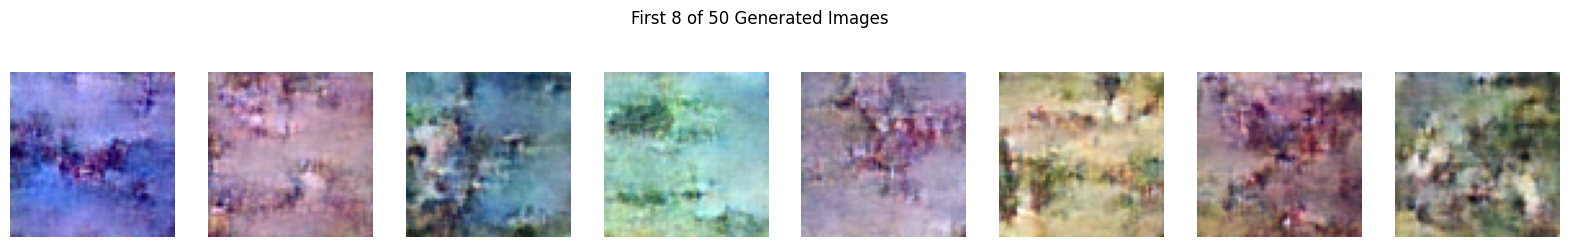

In [ ]:
import torch
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt
import os # Needed to check for file existence

# Imports for potential retraining if model is not found
import datasets
from datasets import load_dataset
from torchvision import transforms
from torch.nn import functional as F
import torch.optim
import huggingface_hub # For dataset loading verbosity
import diffusers # For logging verbosity

# Suppress warnings if retraining happens
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

MODEL_PATH = "animal_diffusion_model.pth"
image_size = 64 # Define image_size as it's used in model and potential retraining

# Load the trained model
model = UNet2DModel(
    sample_size=image_size,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Set up the noise scheduler globally as it's used in both training and generation
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Check if the model weights file exists
if not os.path.exists(MODEL_PATH):
    print(f"Model file '{MODEL_PATH}' not found. Retraining the model...")

    # --- Start of Retraining Logic (copied and adapted from cell 8d9B2sCQjTu2) ---

    # Preprocessing (already defined image_size)
    preprocess = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def transform(examples):
        examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
        return examples

    # Load dataset
    # This might require an internet connection
    try:
        dataset = load_dataset("nirmalendu01/animal_dataset", "images")
        dataset = dataset['train'].select(range(1024))
        dataset.set_transform(transform)
    except Exception as e:
        print(f"Failed to load dataset for retraining: {e}")
        print("Please ensure you have an active internet connection and the dataset exists.")
        raise # Re-raise the error as we cannot proceed without data

    # Create a custom dataset class to return tensors directly
    class TensorDataset(torch.utils.data.Dataset):
        def __init__(self, hf_dataset):
            self.hf_dataset = hf_dataset

        def __len__(self):
            return len(self.hf_dataset)

        def __getitem__(self, idx):
            return self.hf_dataset[idx]["pixel_values"]  # Return tensor directly

    tensor_dataset = TensorDataset(dataset)

    # Create dataloader
    batch_size = 16
    train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # Training loop
    num_epochs = 40  # Adjust as needed
    print(f"Starting retraining for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        for step, batch in enumerate(train_dataloader):
            clean_images = batch.to("cuda")  # Move batch to GPU
            noise_t = torch.randn(clean_images.shape).to("cuda") # Renamed to noise_t to avoid conflict with `noise` for generation
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device="cuda").long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise_t, timesteps)

            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

    # Save the model after retraining
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Model retrained and saved to '{MODEL_PATH}'.")

    # --- End of Retraining Logic ---

# Load the saved model weights (this will execute after retraining if needed, or directly if file exists)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set the model to evaluation mode

# Function to generate images
def generate_images(num_images_to_generate=1):
    with torch.no_grad():  # Disable gradient computation
        # Start from random noise
        # Corrected resolution to 64x64 as per subtask
        noise = torch.randn((num_images_to_generate, 3, image_size, image_size)).to("cuda")
        images = noise

        # Denoising loop
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(images, t).sample

            # Compute the previous noisy sample x_t-1
            images = noise_scheduler.step(noise_pred, t, images).prev_sample

        # Convert images to CPU and denormalize
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        images = torch.clamp(images, 0, 1)  # Clamp to valid pixel range
        return images

# Generate and visualize images
num_images = 50 # Changed to generate 50 images as per subtask
generated_images = generate_images(num_images)

# Plot the generated images
# For visualization, we will only plot a subset of the 50 images to avoid cluttering
# The actual saving of all 50 images will be handled in the next cell.
fig, axes = plt.subplots(1, 8, figsize=(20, 3)) # Displaying 8 images for brevity
for i, img in enumerate(generated_images[:8]): # Plotting first 8 images
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.suptitle(f"First 8 of {num_images} Generated Images")
plt.show()

**Reasoning**:
The previous step successfully generated 50 images and stored them in the `generated_images` variable. Now, to complete the task, I need to save all these images to a directory and then create a zip archive of that directory. I will modify cell `r8S7ReetBggn` to save all 50 generated images individually, and then plot a subset for visualization.



Saving 50 generated images to 'images'...
All 50 images saved.


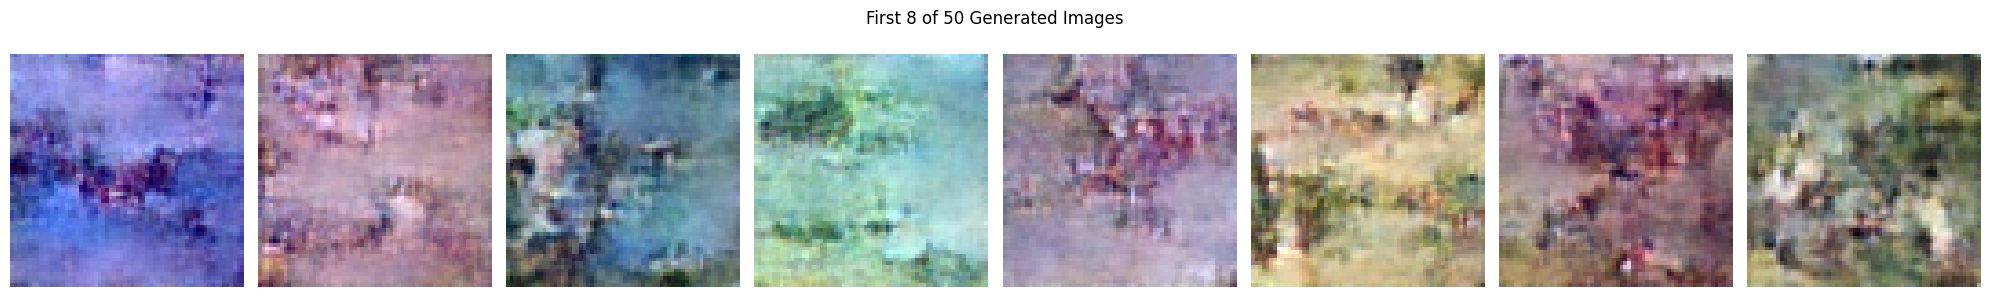

In [ ]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

# Save all generated images individually
print(f"Saving {len(generated_images)} generated images to '{output_dir}'...")
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    # Convert from tensor to numpy for imsave
    img_np = img.numpy()
    # Save each image with a zero-padded two-digit number
    filename = os.path.join(output_dir, f"animal_{i:02d}.png")
    plt.imsave(filename, img_np)
print(f"All {len(generated_images)} images saved.")


# Plot a subset of the generated images for visualization
display_num_images = min(8, len(generated_images)) # Display up to 8 images
fig, axes = plt.subplots(1, display_num_images, figsize=(20, 3))

# Ensure axes is an array even for single image display
if display_num_images == 1:
    axes = [axes]

for i, img in enumerate(generated_images[:display_num_images]):
    img = img.permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.suptitle(f"First {display_num_images} of {len(generated_images)} Generated Images")
plt.tight_layout()
# Save the grid of displayed images (optional, but good for summary)
plt.savefig(os.path.join(output_dir, "animal_grid_subset.png"))
plt.show()

**Reasoning**:
The previous steps have successfully generated and saved 50 images to the 'images' directory. The next logical step, as per the main task, is to zip this directory into 'animals.zip'. This will complete the image saving and archiving part of the task.



In [ ]:
import shutil
import os

# Ensure the directory to be zipped exists
output_dir = "images"
if not os.path.exists(output_dir):
    print(f"Directory '{output_dir}' not found. Cannot create zip archive.")
else:
    # Create a zip archive of the 'images' directory
    shutil.make_archive("animals", "zip", output_dir)
    print("Created animals.zip containing all generated images.")

Created animals.zip containing all generated images.
